# Wine Quality Prediction

# Bon Hee Koo 


The authors of the following research paper:


Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis, “Modeling wine preferences by data mining
from physicochemical properties”, Decision Support Systems, vol. 47, no. 4:547-553, 2009.
considered the problem of modeling wine preferences. Wine can be evaluated by experts who
give a subjective score, and the question the authors of this paper considered was how to build
a model that relates objective features of the wine (e.g., pH values) to its rated quality. For this
project, we will use the data set available at:
http://courses.ieor.berkeley.edu/ieor165/homeworks/winequality-red.csv


Use the following methods to identify the coefficients of a linear model relating wine quality to
different features of the wine: 

(1) ordinary least squares (OLS), (2) ridge regression (RR), (3)
lasso regression. Make sure to include a constant (intercept) term in your model, and choose the
tuning parameters using cross-validation. You may use any programming language you would like
to. For your solutions, please include (i) plots of tuning parameters versus cross-validation error,
(ii) tables of coefficients (labeled by the feature) computed by each method, and (iii) the source
code used to generate the plots and coefficients.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sklearn
import sklearn.datasets
from scipy import stats

In [2]:
wine = pd.read_csv("winequality-red.csv", delimiter=';')

In [3]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
from sklearn.model_selection import train_test_split
X = wine.iloc[:, 0:11]
Y = wine.iloc[:,11]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)


# 1. OLS Model

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import KFold

In [6]:
def mse(y_pred, y_real):
    return np.mean((y_pred - y_real) ** 2)

In [7]:
ols = linear_model.LinearRegression(fit_intercept=True)
ols = ols.fit(X_train,Y_train)

In [8]:
OLS_table = pd.DataFrame(columns=["feature", "coefficient"])
OLS_table["feature"]=X.columns
OLS_table["coefficient"]=ols.coef_
ols_intercept = ols.intercept_

In [9]:
ols_train_predictions = ols.predict(X_train)
ols_train_predictions = np.around(ols_train_predictions, decimals=0).astype(int)
ols_test_predictions = ols.predict(X_test)
ols_test_predictions = np.around(ols_test_predictions, decimals=0).astype(int)

In [10]:
ols_training_error=mse(Y_train, ols_train_predictions)
ols_test_error=mse(Y_test, ols_test_predictions)

# OLS Results

In [11]:
OLS_Results = pd.DataFrame(columns=["OLS Train Error", "OLS Test Error", "OLS Intercept"])
OLS_Results["OLS Train Error"] = [ols_training_error]
OLS_Results["OLS Test Error"] = [ols_test_error]
OLS_Results["OLS Intercept"] = [ols_intercept]
OLS_Results

,OLS Train Error,OLS Test Error,OLS Intercept
0,0.509773,0.46875,0.787758


In [12]:
OLS_table.reset_index(drop=True)

,feature,coefficient
0,fixed acidity,0.012149
1,volatile acidity,-1.099359
2,citric acid,-0.218200
3,residual sugar,0.004405
4,chlorides,-1.744400
5,free sulfur dioxide,0.005350
6,total sulfur dioxide,-0.003173
7,density,3.275691
8,pH,-0.437614
9,sulphates,0.912308


# 2. Ridge Model

In [13]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

First, we focus on finding the best tuning parameter (alpha) by performing cross validation.

In [14]:
ridge_alphas=np.arange(-10,7,.1)
validation_errors =[]
for alpha in ridge_alphas:
    ridge_linear_model = Ridge(alpha=alpha, fit_intercept = True)
    scores = cross_val_score(ridge_linear_model, X_train,Y_train, cv=10,scoring='neg_mean_squared_error')
    validation_errors.append(np.mean(scores))
validation_errors=np.abs(validation_errors)

<ipython-input-15-f2cb8fd8e32f>:6: RuntimeWarning: invalid value encountered in log10
  find_alpha['log alphas']=np.log10(ridge_alphas)


<AxesSubplot:xlabel='log alphas', ylabel='cv_errors'>

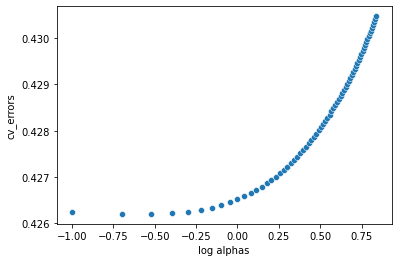

In [15]:
find_alpha=pd.DataFrame(data=ridge_alphas)
find_alpha['cv_errors']=validation_errors
find_alpha = find_alpha.rename({0:'alphas'},axis=1)
min_error = min(find_alpha['cv_errors'])
best_alpha = find_alpha[find_alpha['cv_errors']==min_error]['alphas'].values
find_alpha['log alphas']=np.log10(ridge_alphas)
sns.scatterplot(x="log alphas",y="cv_errors", data = find_alpha)

In [16]:
ridge_linear_model = Ridge(fit_intercept = True, alpha=best_alpha)
ridge_linear_model = ridge_linear_model.fit(X_train,Y_train)
ridge_coef = ridge_linear_model.coef_
ridge_intercept = ridge_linear_model.intercept_
columns = X.columns

In [17]:
ridge_train_predictions = ridge_linear_model.predict(X_train)
ridge_train_predictions = np.around(ridge_train_predictions, decimals=0)
ridge_test_predictions = ridge_linear_model.predict(X_test)
ridge_test_predictions = np.around(ridge_test_predictions, decimals=0)

In [18]:
ridge_table = pd.DataFrame(columns=["feature", "coefficient"])
ridge_table["feature"]=columns
ridge_table["coefficient"]=ridge_coef

In [19]:
ridge_training_error=mse(Y_train, ridge_train_predictions)
ridge_test_error=mse(Y_test, ridge_test_predictions)

# Ridge Results

<AxesSubplot:xlabel='log alphas', ylabel='cv_errors'>

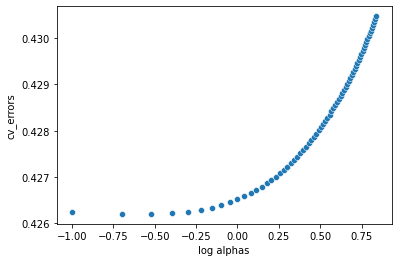

In [20]:
sns.scatterplot(x="log alphas",y="cv_errors", data = find_alpha)

In [21]:
ridge_table.reset_index(drop=True)

,feature,coefficient
0,fixed acidity,0.017403
1,volatile acidity,-1.103193
2,citric acid,-0.226656
3,residual sugar,0.005229
4,chlorides,-1.519919
5,free sulfur dioxide,0.005320
6,total sulfur dioxide,-0.003133
7,density,0.003383
8,pH,-0.397123
9,sulphates,0.885792


In [22]:
Ridge_Results = pd.DataFrame(columns=["Ridge Train Error", "Ridge Test Error", "Ridge_min_cv_error", "Ridge Tuning Alpha","Ridge Intercept"])
Ridge_Results["Ridge Train Error"] = [ridge_training_error]
Ridge_Results["Ridge Test Error"] = [ridge_test_error]
Ridge_Results["Ridge_min_cv_error"] = [min_error]
Ridge_Results["Ridge Tuning Alpha"] = best_alpha
Ridge_Results["Ridge Intercept"] = [ridge_intercept]
Ridge_Results

,Ridge Train Error,Ridge Test Error,Ridge_min_cv_error,Ridge Tuning Alpha,Ridge Intercept
0,0.50821,0.465625,0.426203,0.3,3.87789


# 3. Lasso Model

The cell below focuses on finding the best tuning parameter (beta) for our Lasso Regression model by performing cross validation.

In [23]:
lasso_alphas =np.arange(0.01,1,.01)
lasso_errors =[]
for alpha in lasso_alphas:
    lasso_linear_model = Lasso(alpha=alpha, fit_intercept = True)
    scores = cross_val_score(lasso_linear_model, X_train,Y_train, cv=10,scoring='neg_mean_squared_error')
    lasso_errors.append(np.mean(scores))
lasso_errors=np.abs(lasso_errors)

<AxesSubplot:xlabel='log alphas', ylabel='cv_errors'>

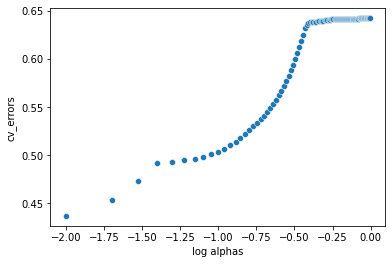

In [24]:
lasso_find_alpha=pd.DataFrame(data=lasso_alphas).rename({0:'lasso_alphas'},axis=1)
lasso_find_alpha['cv_errors']=lasso_errors
lasso_find_alpha['log alphas']=np.log10(lasso_alphas)
lasso_min_error = min(lasso_find_alpha['cv_errors'])
lasso_best_alpha= lasso_find_alpha[lasso_find_alpha['cv_errors']==lasso_min_error]['lasso_alphas'].values
sns.scatterplot(x="log alphas",y="cv_errors", data =lasso_find_alpha)

In [25]:
lasso_model = Lasso(fit_intercept = True, alpha=lasso_best_alpha).fit(X_train,Y_train)
lasso_intercept = lasso_model.intercept_
lasso_table = pd.DataFrame(columns=["feature", "coefficient"])
lasso_table["feature"]=X.columns
lasso_table["coefficient"]=lasso_model.coef_

In [26]:
lasso_train_prediction = np.around(lasso_model.predict(X_train)).astype(int)
lasso_test_prediction = np.around(lasso_model.predict(X_test)).astype(int)

In [27]:
lasso_training_error=mse(Y_train, lasso_train_prediction)
lasso_test_error=mse(Y_test, lasso_test_prediction)

# Lasso Results

<AxesSubplot:xlabel='log alphas', ylabel='cv_errors'>

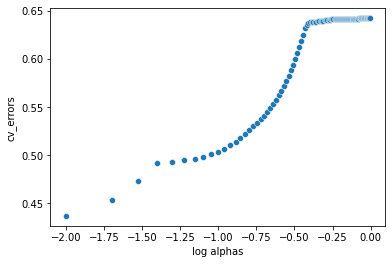

In [28]:
sns.scatterplot(x="log alphas",y="cv_errors", data =lasso_find_alpha)

In [29]:
lasso_table.reset_index(drop=True)

,feature,coefficient
0,fixed acidity,0.034780
1,volatile acidity,-0.843111
2,citric acid,0.000000
3,residual sugar,-0.000000
4,chlorides,-0.000000
5,free sulfur dioxide,0.006318
6,total sulfur dioxide,-0.003211
7,density,-0.000000
8,pH,-0.000000
9,sulphates,0.407620


In [30]:
Lasso_Results = pd.DataFrame(columns=["Lasso Train Error", "Lasso Test Error", "Lasso_min_cv_error", "Lasso Tuning Alpha","Lasso Intercept"])
Lasso_Results["Lasso Train Error"] = [lasso_training_error]
Lasso_Results["Lasso Test Error"] = [lasso_test_error]
Lasso_Results["Lasso_min_cv_error"] = [lasso_min_error]
Lasso_Results["Lasso Tuning Alpha"] = lasso_best_alpha
Lasso_Results["Lasso Intercept"] = [lasso_intercept]
Lasso_Results

,Lasso Train Error,Lasso Test Error,Lasso_min_cv_error,Lasso Tuning Alpha,Lasso Intercept
0,0.521501,0.4625,0.436843,0.01,2.304335
